# Eksik Kütüphanenin yüklenmesi

In [ ]:
!pip install git+https://www.github.com/keras-team/keras-contrib.git

  Cloning https://www.github.com/keras-team/keras-contrib.git to /tmp/pip-req-build-16qjaqno
  Running command git clone -q https://www.github.com/keras-team/keras-contrib.git /tmp/pip-req-build-16qjaqno
  Created wheel for keras-contrib: filename=keras_contrib-2.0.8-py3-none-any.whl size=101077 sha256=20500ca6136f4692246c23e34f9e13f2443181dfd15a37bcfc55c1a99d01b1e9
  Stored in directory: /tmp/pip-ephem-wheel-cache-dv_h19lq/wheels/bb/1f/f2/b57495012683b6b20bbae94a3915ec79753111452d79886abc
Successfully built keras-contrib


# Veri setinin indirilmesi

In [ ]:
!mkdir datasets

## apple2orange

In [ ]:
!wget -N https://people.eecs.berkeley.edu/~taesung_park/CycleGAN/datasets/apple2orange.zip -O datasets/apple2orange.zip
!mkdir datasets/apple2orange/
!unzip -q datasets/apple2orange.zip -d ./datasets/
!rm datasets/apple2orange.zip

for details.

--2022-05-15 09:36:58--  https://people.eecs.berkeley.edu/~taesung_park/CycleGAN/datasets/apple2orange.zip
Resolving people.eecs.berkeley.edu (people.eecs.berkeley.edu)... 128.32.244.190
Connecting to people.eecs.berkeley.edu (people.eecs.berkeley.edu)|128.32.244.190|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 78456409 (75M) [application/zip]
Saving to: ‘datasets/apple2orange.zip’

datasets/apple2oran 100%[===================>]  74.82M  32.4MB/s    in 2.3s    

2022-05-15 09:37:00 (32.4 MB/s) - ‘datasets/apple2orange.zip’ saved [78456409/78456409]



## horse2zebra

In [ ]:
!wget -N https://people.eecs.berkeley.edu/~taesung_park/CycleGAN/datasets/horse2zebra.zip -O datasets/horse2zebra.zip
!mkdir datasets/horse2zebra/
!unzip -q datasets/horse2zebra.zip -d ./datasets/
!rm datasets/horse2zebra.zip

for details.

--2022-05-15 09:37:02--  https://people.eecs.berkeley.edu/~taesung_park/CycleGAN/datasets/horse2zebra.zip
Resolving people.eecs.berkeley.edu (people.eecs.berkeley.edu)... 128.32.244.190
Connecting to people.eecs.berkeley.edu (people.eecs.berkeley.edu)|128.32.244.190|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 116867962 (111M) [application/zip]
Saving to: ‘datasets/horse2zebra.zip’

datasets/horse2zebr 100%[===================>] 111.45M  33.9MB/s    in 3.3s    

2022-05-15 09:37:05 (33.9 MB/s) - ‘datasets/horse2zebra.zip’ saved [116867962/116867962]



Google Drive ın bağlanması

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


# Kütüphaneler

In [ ]:
from __future__ import print_function, division
from tensorflow.keras.datasets import mnist
from keras_contrib.layers.normalization.instancenormalization import InstanceNormalization
from tensorflow.keras.layers import Input, Dense, Reshape, Flatten, Dropout, Concatenate
from tensorflow.keras.layers import BatchNormalization, Activation, ZeroPadding2D
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import UpSampling2D, Conv2D
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam
import datetime
import matplotlib.pyplot as plt
import sys
import numpy as np
import os

import cv2
from glob import glob

# Data Loader

In [ ]:
class DataLoader():
    def __init__(self, dataset_name, img_res=(128, 128)):
        self.dataset_name = dataset_name
        self.img_res = img_res

    def load_data(self, domain, batch_size=1, is_testing=False):
        data_type = "train%s" % domain if not is_testing else "test%s" % domain
        path = glob('./datasets/%s/%s/*' % (self.dataset_name, data_type))

        batch_images = np.random.choice(path, size=batch_size)

        imgs = []
        for img_path in batch_images:
            img = self.imread(img_path)
            if not is_testing:
                #img = scipy.misc.imresize(img, self.img_res)
                img = cv2.resize(img, self.img_res)

                if np.random.random() > 0.5:
                    img = np.fliplr(img)
            else:
                #img = scipy.misc.imresize(img, self.img_res)
                img = cv2.resize(img, self.img_res)
            imgs.append(img)

        imgs = np.array(imgs)/127.5 - 1.

        return imgs

    def load_batch(self, batch_size=1, is_testing=False):
        data_type = "train" if not is_testing else "val"
        path_A = glob('./datasets/%s/%sA/*' % (self.dataset_name, data_type))
        path_B = glob('./datasets/%s/%sB/*' % (self.dataset_name, data_type))

        self.n_batches = int(min(len(path_A), len(path_B)) / batch_size)
        total_samples = self.n_batches * batch_size

        # Sample n_batches * batch_size from each path list so that model sees all
        # samples from both domains
        path_A = np.random.choice(path_A, total_samples, replace=False)
        path_B = np.random.choice(path_B, total_samples, replace=False)

        for i in range(self.n_batches-1):
            batch_A = path_A[i*batch_size:(i+1)*batch_size]
            batch_B = path_B[i*batch_size:(i+1)*batch_size]
            imgs_A, imgs_B = [], []
            for img_A, img_B in zip(batch_A, batch_B):
                img_A = self.imread(img_A)
                img_B = self.imread(img_B)

                #img_A = scipy.misc.imresize(img_A, self.img_res)
                #img_B = scipy.misc.imresize(img_B, self.img_res)
                img_A = cv2.resize(img_A, self.img_res)
                img_B = cv2.resize(img_B, self.img_res)

                if not is_testing and np.random.random() > 0.5:
                        img_A = np.fliplr(img_A)
                        img_B = np.fliplr(img_B)

                imgs_A.append(img_A)
                imgs_B.append(img_B)

            imgs_A = np.array(imgs_A)/127.5 - 1.
            imgs_B = np.array(imgs_B)/127.5 - 1.

            yield imgs_A, imgs_B


    def load_img(self, path):
        #img = self.imread(path)
        #img = scipy.misc.imresize(img, self.img_res)
        img = cv2.imread(path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, self.img_res)
        img = img/127.5 - 1.
        return img[np.newaxis, :, :, :]


    def imread(self, path):
        img = cv2.imread(path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        return img
        #return scipy.misc.imread(path, mode='RGB').astype(np.float)


# Cycle Gan Modeli

In [ ]:
class CycleGAN():
    def __init__(self, dataset_name):
        # Input shape
        self.img_rows = 128
        self.img_cols = 128
        self.channels = 3
        self.img_shape = (self.img_rows, self.img_cols, self.channels)

        # Configure data loader
        self.dataset_name = dataset_name
        self.data_loader = DataLoader(dataset_name=self.dataset_name,
                                      img_res=(self.img_rows, self.img_cols))

        # Calculate output shape of D (PatchGAN)
        patch = int(self.img_rows / 2**4)
        self.disc_patch = (patch, patch, 1)

        # Number of filters in the first layer of G and D
        self.gf = 32
        self.df = 64

        # Loss weights
        self.lambda_cycle = 10.0                    # Cycle-consistency loss
        self.lambda_id = 0.1 * self.lambda_cycle    # Identity loss

        optimizer = Adam(0.0002, 0.5)

        # Build and compile the discriminators
        self.d_A = self.build_discriminator()
        self.d_B = self.build_discriminator()
        self.d_A.compile(loss='mse',
            optimizer=optimizer,
            metrics=['accuracy'])
        self.d_B.compile(loss='mse',
            optimizer=optimizer,
            metrics=['accuracy'])

        #-------------------------
        # Construct Computational
        #   Graph of Generators
        #-------------------------

        # Build the generators
        self.g_AB = self.build_generator()
        self.g_BA = self.build_generator()

        # Input images from both domains
        img_A = Input(shape=self.img_shape)
        img_B = Input(shape=self.img_shape)

        # Translate images to the other domain
        fake_B = self.g_AB(img_A)
        fake_A = self.g_BA(img_B)
        # Translate images back to original domain
        reconstr_A = self.g_BA(fake_B)
        reconstr_B = self.g_AB(fake_A)
        # Identity mapping of images
        img_A_id = self.g_BA(img_A)
        img_B_id = self.g_AB(img_B)

        # For the combined model we will only train the generators
        self.d_A.trainable = False
        self.d_B.trainable = False

        # Discriminators determines validity of translated images
        valid_A = self.d_A(fake_A)
        valid_B = self.d_B(fake_B)

        # Combined model trains generators to fool discriminators
        self.combined = Model(inputs=[img_A, img_B],
                              outputs=[ valid_A, valid_B,
                                        reconstr_A, reconstr_B,
                                        img_A_id, img_B_id ])
        self.combined.compile(loss=['mse', 'mse',
                                    'mae', 'mae',
                                    'mae', 'mae'],
                            loss_weights=[  1, 1,
                                            self.lambda_cycle, self.lambda_cycle,
                                            self.lambda_id, self.lambda_id ],
                            optimizer=optimizer)

    def build_generator(self):
        """U-Net Generator"""

        def conv2d(layer_input, filters, f_size=4):
            """Layers used during downsampling"""
            d = Conv2D(filters, kernel_size=f_size, strides=2, padding='same')(layer_input)
            d = LeakyReLU(alpha=0.2)(d)
            d = InstanceNormalization()(d)
            return d

        def deconv2d(layer_input, skip_input, filters, f_size=4, dropout_rate=0):
            """Layers used during upsampling"""
            u = UpSampling2D(size=2)(layer_input)
            u = Conv2D(filters, kernel_size=f_size, strides=1, padding='same', activation='relu')(u)
            if dropout_rate:
                u = Dropout(dropout_rate)(u)
            u = InstanceNormalization()(u)
            u = Concatenate()([u, skip_input])
            return u

        # Image input
        d0 = Input(shape=self.img_shape)

        # Downsampling
        d1 = conv2d(d0, self.gf)
        d2 = conv2d(d1, self.gf*2)
        d3 = conv2d(d2, self.gf*4)
        d4 = conv2d(d3, self.gf*8)

        # Upsampling
        u1 = deconv2d(d4, d3, self.gf*4)
        u2 = deconv2d(u1, d2, self.gf*2)
        u3 = deconv2d(u2, d1, self.gf)

        u4 = UpSampling2D(size=2)(u3)
        output_img = Conv2D(self.channels, kernel_size=4, strides=1, padding='same', activation='tanh')(u4)

        return Model(d0, output_img)

    def build_discriminator(self):

        def d_layer(layer_input, filters, f_size=4, normalization=True):
            """Discriminator layer"""
            d = Conv2D(filters, kernel_size=f_size, strides=2, padding='same')(layer_input)
            d = LeakyReLU(alpha=0.2)(d)
            if normalization:
                d = InstanceNormalization()(d)
            return d

        img = Input(shape=self.img_shape)

        d1 = d_layer(img, self.df, normalization=False)
        d2 = d_layer(d1, self.df*2)
        d3 = d_layer(d2, self.df*4)
        d4 = d_layer(d3, self.df*8)

        validity = Conv2D(1, kernel_size=4, strides=1, padding='same')(d4)

        return Model(img, validity)

    def train(self, epochs, batch_size=1, sample_interval=50):

        start_time = datetime.datetime.now()

        # Adversarial loss ground truths
        valid = np.ones((batch_size,) + self.disc_patch)
        fake = np.zeros((batch_size,) + self.disc_patch)

        for epoch in range(epochs):
            for batch_i, (imgs_A, imgs_B) in enumerate(self.data_loader.load_batch(batch_size)):

                # ----------------------
                #  Train Discriminators
                # ----------------------

                # Translate images to opposite domain
                fake_B = self.g_AB.predict(imgs_A)
                fake_A = self.g_BA.predict(imgs_B)

                # Train the discriminators (original images = real / translated = Fake)
                dA_loss_real = self.d_A.train_on_batch(imgs_A, valid)
                dA_loss_fake = self.d_A.train_on_batch(fake_A, fake)
                dA_loss = 0.5 * np.add(dA_loss_real, dA_loss_fake)

                dB_loss_real = self.d_B.train_on_batch(imgs_B, valid)
                dB_loss_fake = self.d_B.train_on_batch(fake_B, fake)
                dB_loss = 0.5 * np.add(dB_loss_real, dB_loss_fake)

                # Total disciminator loss
                d_loss = 0.5 * np.add(dA_loss, dB_loss)


                # ------------------
                #  Train Generators
                # ------------------

                # Train the generators
                g_loss = self.combined.train_on_batch([imgs_A, imgs_B],
                                                        [valid, valid,
                                                        imgs_A, imgs_B,
                                                        imgs_A, imgs_B])

                elapsed_time = datetime.datetime.now() - start_time

                # Plot the progress
                print ("[Epoch %d/%d] [Batch %d/%d] [D loss: %f, acc: %3d%%] [G loss: %05f, adv: %05f, recon: %05f, id: %05f] time: %s " \
                                                                        % ( epoch, epochs,
                                                                            batch_i, self.data_loader.n_batches,
                                                                            d_loss[0], 100*d_loss[1],
                                                                            g_loss[0],
                                                                            np.mean(g_loss[1:3]),
                                                                            np.mean(g_loss[3:5]),
                                                                            np.mean(g_loss[5:6]),
                                                                            elapsed_time))

                # If at save interval => save generated image samples
                if batch_i % sample_interval == 0:
                    self.sample_images(epoch, batch_i)

    def sample_images(self, epoch, batch_i):
        os.makedirs('images/%s' % self.dataset_name, exist_ok=True)
        r, c = 2, 3

        imgs_A = self.data_loader.load_data(domain="A", batch_size=1, is_testing=True)
        imgs_B = self.data_loader.load_data(domain="B", batch_size=1, is_testing=True)

        # Demo (for GIF)
        #imgs_A = self.data_loader.load_img('datasets/apple2orange/testA/n07740461_1541.jpg')
        #imgs_B = self.data_loader.load_img('datasets/apple2orange/testB/n07749192_4241.jpg')

        # Translate images to the other domain
        fake_B = self.g_AB.predict(imgs_A)
        fake_A = self.g_BA.predict(imgs_B)
        # Translate back to original domain
        reconstr_A = self.g_BA.predict(fake_B)
        reconstr_B = self.g_AB.predict(fake_A)

        gen_imgs = np.concatenate([imgs_A, fake_B, reconstr_A, imgs_B, fake_A, reconstr_B])

        # Rescale images 0 - 1
        gen_imgs = 0.5 * gen_imgs + 0.5

        titles = ['Original', 'Translated', 'Reconstructed']
        fig, axs = plt.subplots(r, c)
        cnt = 0
        for i in range(r):
            for j in range(c):
                axs[i,j].imshow(gen_imgs[cnt])
                axs[i, j].set_title(titles[j])
                axs[i,j].axis('off')
                cnt += 1
        fig.savefig("images/%s/%d_%d.png" % (self.dataset_name, epoch, batch_i))
        plt.close()

# apple2orange eğitimi

In [ ]:
gan = CycleGAN("apple2orange")
gan.train(epochs=101, batch_size=64, sample_interval=200)

[Epoch 0/101] [Batch 0/15] [D loss: 23.236288, acc:  30%] [G loss: 158.579956, adv: 71.504004, recon: 0.705673, id: 0.579856] time: 0:00:28.115890 
[Epoch 0/101] [Batch 1/15] [D loss: 41.917259, acc:  53%] [G loss: 85.972000, adv: 33.241338, recon: 0.907070, id: 0.430149] time: 0:00:31.370814 
[Epoch 0/101] [Batch 2/15] [D loss: 19.995437, acc:  49%] [G loss: 35.111618, adv: 8.394692, recon: 0.838190, id: 0.516747] time: 0:00:33.639474 
[Epoch 0/101] [Batch 3/15] [D loss: 10.349386, acc:  43%] [G loss: 20.292334, adv: 1.426057, recon: 0.790811, id: 0.577559] time: 0:00:35.863990 
[Epoch 0/101] [Batch 4/15] [D loss: 1.302905, acc:  50%] [G loss: 20.295723, adv: 2.264581, recon: 0.699682, id: 0.704324] time: 0:00:38.082890 
[Epoch 0/101] [Batch 5/15] [D loss: 0.955632, acc:  70%] [G loss: 16.039970, adv: 0.855926, recon: 0.619240, id: 0.900860] time: 0:00:40.295304 
[Epoch 0/101] [Batch 6/15] [D loss: 0.489302, acc:  46%] [G loss: 14.597439, adv: 0.580037, recon: 0.571350, id: 0.968209] 

## Örnek Görseller

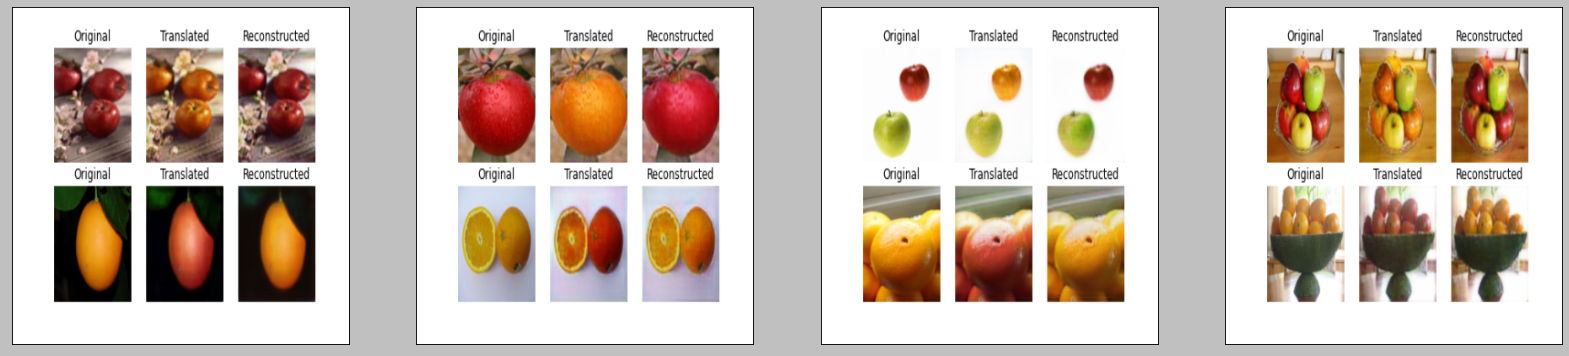

In [ ]:
plt.figure(figsize = (25, 50), dpi = 80, facecolor = 'silver', edgecolor = 'gray')


last_samples = [os.path.join("/content/images/apple2orange", img_name)
		for img_name in os.listdir("/content/images/apple2orange")
		if img_name.startswith("100") or img_name.startswith("99") or img_name.startswith("98") or img_name.startswith("97")]


for index, i in enumerate(last_samples):
    plt.subplot(1, 4, index+1)
    img = cv2.imread(i)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB )
    img = cv2.resize(img, (400, 400) )

    plt.imshow(img)
    plt.xticks([]), plt.yticks([])

plt.show()

# horse2zebra eğitimi

In [ ]:
gan = CycleGAN("horse2zebra")
gan.train(epochs=101, batch_size=64, sample_interval=200)

[Epoch 0/101] [Batch 0/16] [D loss: 30.778631, acc:  11%] [G loss: 35.234627, adv: 8.583424, recon: 0.829298, id: 0.915907] time: 0:00:13.338247 
[Epoch 0/101] [Batch 1/16] [D loss: 7.868747, acc:  85%] [G loss: 22.427143, adv: 2.880494, recon: 0.761376, id: 0.907242] time: 0:00:16.370114 
[Epoch 0/101] [Batch 2/16] [D loss: 8.513883, acc:  29%] [G loss: 47.907848, adv: 16.725371, recon: 0.656569, id: 0.751266] time: 0:00:18.728879 
[Epoch 0/101] [Batch 3/16] [D loss: 3.598124, acc:  50%] [G loss: 23.625044, adv: 2.608774, recon: 0.841949, id: 1.025220] time: 0:00:21.084352 
[Epoch 0/101] [Batch 4/16] [D loss: 2.313194, acc:  42%] [G loss: 27.770805, adv: 4.669776, recon: 0.837328, id: 1.073152] time: 0:00:23.365500 
[Epoch 0/101] [Batch 5/16] [D loss: 1.825923, acc:  54%] [G loss: 18.512039, adv: 0.777752, recon: 0.765891, id: 1.047504] time: 0:00:25.659852 
[Epoch 0/101] [Batch 6/16] [D loss: 0.683114, acc:  60%] [G loss: 20.546555, adv: 3.348189, recon: 0.605217, id: 1.041685] time:

## Örnek Görseller

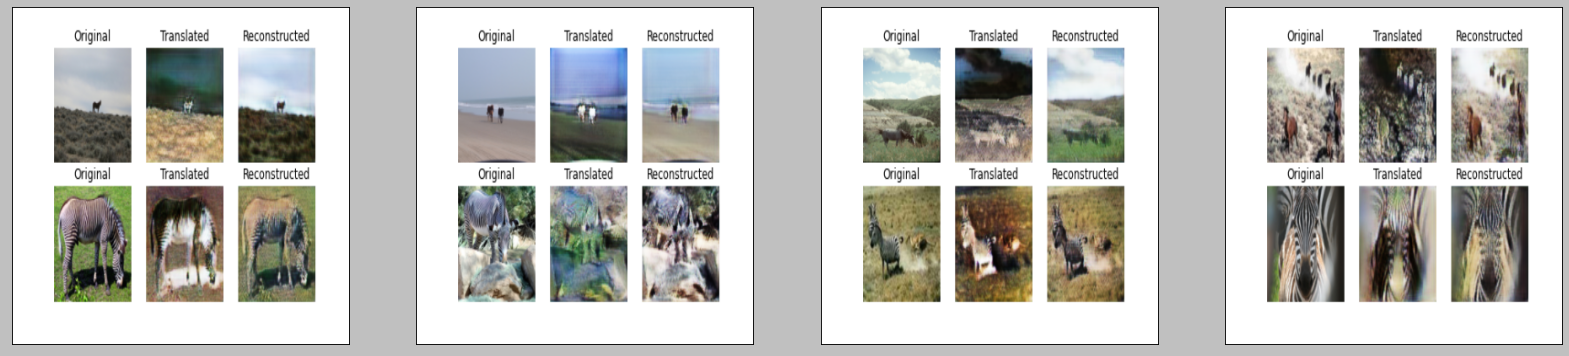

In [ ]:
plt.figure(figsize = (25, 50), dpi = 80, facecolor = 'silver', edgecolor = 'gray')


last_samples = [os.path.join("/content/images/horse2zebra", img_name)
		for img_name in os.listdir("/content/images/horse2zebra")
		if img_name.startswith("100") or img_name.startswith("99") or img_name.startswith("98") or img_name.startswith("97")]
    

for index, i in enumerate(last_samples):
    plt.subplot(1, 4, index+1)
    img = cv2.imread(i)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB )
    img = cv2.resize(img, (400, 400) )

    plt.imshow(img)
    plt.xticks([]), plt.yticks([])

plt.show()

# Örneklerin drive a taşınması

In [ ]:
!cp -r images /content/gdrive/MyDrive/

## **Kaynakça**
Unpaired Image-to-Image Translation using Cycle-Consistent Adversarial Networks 
Unpaired Image-to-Image Translation using Cycle-Consistent Adversarial Networks 
CycleGAN: Learning to Translate Images 
How to Implement CycleGAN Models From Scratch With Keras
How to use the UpSampling2D and Conv2DTranspose Layers in Keras

Jun-Yan Zhu*, Taesung Park*, Phillip Isola, and Alexei A. Efros. "Unpaired Image-to-Image Translation using Cycle-Consistent Adversarial Networks", in IEEE International Conference on Computer Vision (ICCV), 2017. https://arxiv.org/pdf/1805.08841.pdf
